Requires `usgs_cleaned_with_masses.csv` which is produced by the `compute_masses.ipynb` notebook, or available on Box at `data/model inputs and outputs`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

from celavi.simple_model import Context

np.random.seed(123)

## Import the USGS data

In [2]:
usgs = pd.read_csv("usgs_cleaned_with_masses.csv")
usgs.dropna(axis=0, subset=["p_year"], inplace=True)
usgs = usgs.query("p_year >= 2000")
print(len(usgs))
usgs.head()

57600


,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,t_cap_filled,t_rd_filled,blade_mass_tonnes
160,3049503,19-028064,2014-WTE-4083-OE,NaN,NaN,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,150.0,3,3,5/13/2017,Digital Globe,-93.523651,42.006813,3000.0,125.0,37.74
161,3053390,19-028015,2015-WTE-6386-OE,NaN,NaN,IA,Boone County,19015,30 MW Iowa DG Portfolio,2017.0,...,150.0,3,3,6/1/2017,Digital Globe,-93.700424,41.977608,3000.0,125.0,37.74
162,3049500,19-028030,2014-WTE-4080-OE,NaN,NaN,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,150.0,3,3,5/13/2017,Digital Globe,-93.515892,42.016373,3000.0,125.0,37.74
163,3063272,19-028134,2014-WTE-4084-OE,NaN,NaN,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,150.0,3,3,4/24/2017,Digital Globe,-93.430367,42.028233,3000.0,125.0,37.74
164,3063269,19-028130,2016-WTE-5934-OE,NaN,NaN,IA,Story County,19169,30 MW Iowa DG Portfolio,2017.0,...,150.0,3,3,7/23/2017,Digital Globe,-93.632835,41.882477,3000.0,125.0,37.74


In [3]:
components = []
for _, turbine in usgs.iterrows():
    xlong = turbine["xlong"]
    ylat = turbine["ylat"]
    year = turbine["p_year"]
    blade_mass_tonnes = int(turbine["blade_mass_tonnes"])
    
    components.append({
        "kind": "blade",
        "xlong": xlong,
        "ylat": ylat,
        "year": year,
        "mass_tonnes": blade_mass_tonnes,
    })
    
    components.append({
        "kind": "blade",
        "xlong": xlong,
        "ylat": ylat,
        "year": year,
        "mass_tonnes": blade_mass_tonnes,
    })
    
    components.append({
        "kind": "blade",
        "xlong": xlong,
        "ylat": ylat,
        "year": year,
        "mass_tonnes": blade_mass_tonnes,
    })
    
    components.append({
        "kind": "foundation",
        "xlong": xlong,
        "ylat": ylat,
        "year": year,
        "mass_tonnes": 1,
    })
    
    components.append({
        "kind": "tower",
        "xlong": xlong,
        "ylat": ylat,
        "year": year,
        "mass_tonnes": 1,
    })
    
    components.append({
        "kind": "nacelle",
        "xlong": xlong,
        "ylat": ylat,
        "year": year,
        "mass_tonnes": 1,
    })
    
components = pd.DataFrame(components)

## Run the DES model

Populate the components, run the DES model, extract the inventory levels

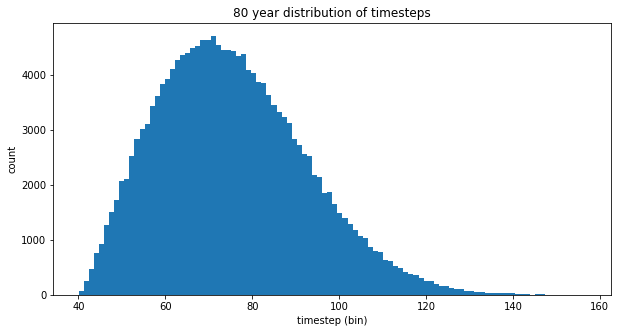

In [4]:
# All lifespans in the model are in discrete timesteps
timesteps_per_year = 4

lifespans = [20 * timesteps_per_year]
landfill_inventories = {}
landfill_mass_inventories = {}
max_timesteps = 281
K = 2.2   # DES Weibull shape parameter from Aubryn's study
min_lifespan = 10 * timesteps_per_year  # From Faulstitch et al

for lifespan in lifespans:
    L = lifespan  # DES Weibull scale parameter

    lifespan_fns = {
        "nacelle": lambda: 30,
        "blade": lambda: weibull_min.rvs(K, loc=min_lifespan, scale=L-min_lifespan, size=1)[0],
#         "blade": lambda: weibull_min.rvs(K, loc=0, scale=L, size=1)[0],
        "foundation": lambda: 50,
        "tower": lambda: 50,
    }
    context = Context(max_timesteps=max_timesteps)
    context.populate(components, lifespan_fns)
    
    # Make histogram about lifespans
    component_lifespans = [component.lifespan for component in context.components if component.kind == "blade"]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    ax.set_title(f"{lifespan} year distribution of timesteps")
    ax.set_ylabel("count")
    ax.set_xlabel("timestep (bin)")
    ax.hist(component_lifespans, bins=100)
    
    landfill_inventory, landfill_mass_inventory = context.run()
    landfill_inventories[lifespan] = landfill_inventory
    landfill_mass_inventories[lifespan] = landfill_mass_inventory

## Display the results on a plot

First, results since 2020 (timestep 160)

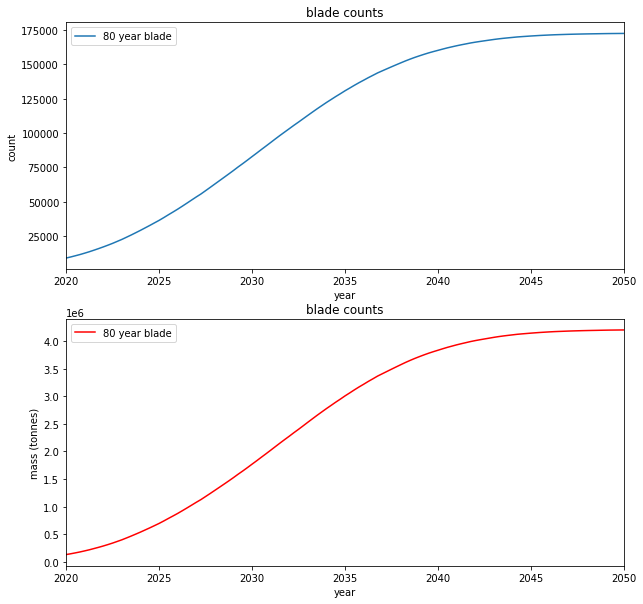

In [5]:
years = np.arange(max_timesteps) / 4 + 1980
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

for lifespan_yr, inventories in landfill_inventories.items():
    xs = years[160:]
    ys = inventories.loc[160:, "blade"]
    axs[0].plot(xs, ys, label=f"{lifespan_yr} year blade")
    axs[0].set_title("blade counts")
    axs[0].set_ylabel("count")
    axs[0].set_xlabel("year")
axs[0].set_xlim(xs.min(), xs.max())
axs[0].legend(loc="best")

for lifespan_yr, inventory_mass in landfill_mass_inventories.items():
    xs = years[160:]
    ys = inventory_mass.loc[160:, "blade"]
    axs[1].plot(xs, ys, color="r", label=f"{lifespan_yr} year blade")
    axs[1].set_title("blade counts")
    axs[1].set_ylabel("mass (tonnes)")
    axs[1].set_xlabel("year")
axs[1].set_xlim(xs.min(), xs.max())
axs[1].legend(loc="best")

Then results since 1980

## Examine the results in a table

Table of annual component counts since 2020.

In [6]:
landfill = landfill_inventories[20 * timesteps_per_year].copy()
landfill.rename(columns={"blade": "cumulative_blade_DES"}, inplace=True)
landfill_years = np.arange(len(landfill)) / 4 + 1980
landfill["year"] = landfill_years
every_year_since_2020 = landfill.loc[160::4, ["year", "cumulative_blade_DES"]]
every_year_since_2020

,year,cumulative_blade_DES
160,2020.0,8907.0
164,2021.0,12479.0
168,2022.0,17025.0
172,2023.0,22496.0
176,2024.0,29111.0
180,2025.0,36364.0
184,2026.0,44539.0
188,2027.0,53441.0
192,2028.0,62883.0
196,2029.0,72725.0


Table of components masses since 2020

In [7]:
landfill_mass = landfill_mass_inventories[20 * timesteps_per_year].copy()
landfill_mass.rename(columns={"blade": "cumulative_blade_mass_DES"}, inplace=True)
landfill_mass_years = np.arange(len(landfill_mass)) / 4 + 1980
landfill_mass["year"] = landfill_mass_years
mass_every_year_since_2020 = landfill_mass.loc[160::4, ["year", "cumulative_blade_mass_DES"]]
mass_every_year_since_2020

,year,cumulative_blade_mass_DES
160,2020.0,132393.0
164,2021.0,199019.0
168,2022.0,287645.0
172,2023.0,399666.0
176,2024.0,539379.0
180,2025.0,695894.0
184,2026.0,877062.0
188,2027.0,1078503.0
192,2028.0,1294995.0
196,2029.0,1525433.0


In [8]:
mass_every_year_since_2020.to_csv("blade_mass_des.csv", index=False)
every_year_since_2020.to_csv("blade_counts_des.csv", index=False)

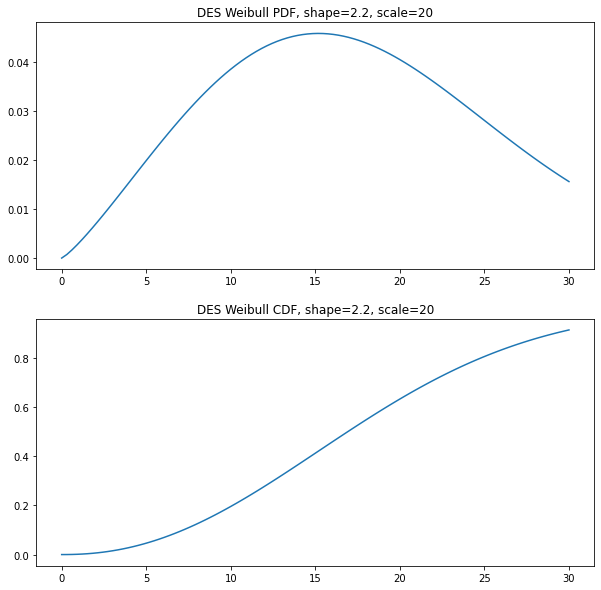

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
L = 20
K = 2.2

des_weibull_1 = weibull_min(K, scale=L)
des_weibull_2 = weibull_min(K, loc=min_lifespan, scale=L-min_lifespan)
des_xs = np.linspace(0, 30, 100)
ax[0].plot(des_xs, des_weibull_1.pdf(des_xs))
ax[0].plot(des_xs, des_weibull_2.pdf(des_xs), color="r")
ax[0].set_title(f"DES Weibull PDF, shape={K}, scale={L}")
ax[1].plot(des_xs, des_weibull_1.cdf(des_xs))
ax[1].plot(des_xs, des_weibull_2.cdf(des_xs), color="r")
ax[1].set_title(f"DES Weibull CDF, shape={K}, scale={L}")

plt.show()